In [1]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Query a Remote LangGraph Agent Server

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fsample-apps%2Fgenai-experience-concierge%2Flanggraph-demo%2Fbackend%2Fnotebooks%2Flanggraph-remote-agent.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/sample-apps/genai-experience-concierge/langgraph-demo/backend/notebooks/langgraph-remote-agent.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>

| | |
|-|-|
|Author(s) | [Pablo Gaeta](https://github.com/pablofgaeta) |

## Overview

This notebook demonstrates example usage of a deployed agent using the standard LangGraph `RemoteGraph` client. The notebook can be configured to point to a locally running instance or a deployed server (e.g. on Cloud Run).

Some test queries have been added for the basic `gemini` agent that will stream chunks of text. This interactive notebook might be useful for a frontend team developing a custom user interface for the agent.

Feel free to add new cells and experiment with streaming outputs from the other agent implementations (Check out the [frontend code](../../frontend/concierge_ui/pages/) for inspiration).

## Import dependencies

In [2]:
import uuid
import json

from IPython import display as ipd
from langgraph.pregel import remote

## Configure notebook parameters

By default, the notebook points to a local server at port 3000. Parameters for a remote deployed endpoint might look like:

```python
import subprocess

agent_name = "..."
agent_url = f"https://concierge-XXXXXXXXXX-uc.a.run.app/{agent_name}"
id_token = subprocess.run(
    ["gcloud", "auth", "print-identity-token"], capture_output=True, text=True
).stdout.strip()
```

In [3]:
agent_name = "task-planner"
agent_url = f"http://127.0.0.1:3000/{agent_name}"
id_token = None

# Configure remote agent pointing to local development server
graph = remote.RemoteGraph(
    agent_name,
    url=agent_url,
    headers={"Authorization": f"Bearer {id_token}"} if id_token else {},
)

test_thread = f"test-{uuid.uuid4().hex}"

## Query the Remote Agent

Display graph visualization

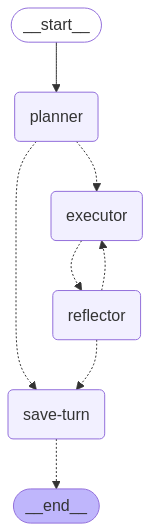

In [4]:
ipd.Image(graph.get_graph().draw_mermaid_png())

Utility function to handle chunks across all agents. Not very practical in practice but useful for demo purposes.

In [5]:
def handle_chunk(chunk: dict, task_idx: int = 0) -> tuple[str, str]:
    if "text" in chunk:
        text = chunk["text"]
        return "text", text

    elif "response" in chunk:
        text = chunk["response"]
        return "response", text

    elif "guardrail_classification" in chunk:
        is_blocked = chunk["guardrail_classification"]["blocked"]
        classification_emoji = "❌" if is_blocked else "✅"
        reason = chunk["guardrail_classification"]["reason"]

        text = f"Guardrail classification: {classification_emoji}\n\nReason: {reason}"

        return "guardrail_classification", text

    elif "router_classification" in chunk:
        target = chunk["router_classification"]["target"]
        reason = chunk["router_classification"]["reason"]

        text = f"Agent Classification: {target}\n\nReason: {reason}"

        return "router_classification", text

    elif "function_call" in chunk:
        function_call_dict = chunk["function_call"]

        fn_name = function_call_dict.get("name") or "unknown"
        fn_args = function_call_dict.get("args") or {}

        fn_args_string = ", ".join(f"{k}={v}" for k, v in fn_args.items())
        fn_string = f"**{fn_name}**({fn_args_string})"

        text = f"Calling function... {fn_string}"

        return "fn_call", text

    elif "function_response" in chunk:
        function_response_dict = chunk["function_response"]

        fn_name = function_response_dict.get("name") or "unknown"

        if function_response_dict.get("response") is None:
            text = f"Received empty function response (name={fn_name})."

        elif "result" in function_response_dict.get("response"):
            fn_result = function_response_dict["response"]["result"]
            text = "\n\n".join(
                [
                    f"Function result for **{fn_name}**...",
                    "```json",
                    json.dumps(fn_result, indent=2),
                    "```",
                ]
            )

        elif "error" in function_response_dict.get("response"):
            fn_result = function_response_dict["response"]["error"]
            text = f"Function error (name={fn_name})... {fn_result}"

        return "fn_response", text

    elif "plan" in chunk:
        plan_dict = chunk["plan"]
        plan_string = _stringify_plan(plan=plan_dict, include_results=False)
        text = f"### Generated execution plan...\n\n{plan_string}"

        return "plan", text

    elif "executed_task" in chunk:
        task_idx += 1
        task_dict = chunk["executed_task"]
        task_string = _stringify_task(task=task_dict, include_results=True)
        text = f"### Executed task #{task_idx}...\n\n{task_string}"

        return f"executed_task_{task_idx}", text

    elif "error" in chunk:
        text = chunk["error"]

        return "error", text

    else:
        text = f"Unhandled chunk. keys={set(chunk.keys())}"

        return "unhandled", text


def _stringify_plan(plan: dict, include_results: bool = True) -> str:
    """Formats an execution plan dictionary into a human-readable string."""
    tasks_str = "\n\n".join(
        f"**Task #{idx + 1}**\n\n"
        + _stringify_task(task, include_results=include_results)
        for idx, task in enumerate(plan["tasks"])
    )

    response = f"**Plan**: {plan['goal']}\n\n{tasks_str}"

    return response


def _stringify_task(task: dict, include_results: bool = True) -> str:
    """Formats a task dictionary into a human-readable string."""
    output = f"**Goal**: {task['goal']}"

    if include_results:
        output += f"\n\n**Result**: {task.get('result') or 'incomplete'}"

    return output

Run a query in stream mode **_without_** custom stream writer. Streams node updates, not text stream.

In [6]:
for chunk in graph.stream(
    input={"current_turn": {"user_input": "hi"}},
    config={"configurable": {"thread_id": test_thread}},
    stream_mode="updates",
):
    print(chunk)

{'planner': {'current_turn': {'user_input': 'hi', 'response': 'Hello there! How can I help you today?'}}}
{'save-turn': {'current_turn': None, 'turns': [{'user_input': 'hi', 'response': 'Hello there! How can I help you today?'}]}}


Run a query in stream mode **_with_** the custom stream writer mode. Streams text generated by Gemini to stdout.

In [7]:
task_idx = 0
response_text = ""
current_source = last_source = None
for stream_mode, chunk in graph.stream(
    input={"current_turn": {"user_input": "what products does Cymbal Retail sell?"}},
    config={"configurable": {"thread_id": test_thread}},
    stream_mode=["updates", "custom"],
):
    if stream_mode == "custom":
        assert isinstance(chunk, dict), "Expected dictionary data"

        current_source, text = handle_chunk(chunk, task_idx)

        if "executed_task" in current_source:
            task_idx += 1

        if last_source is not None and last_source != current_source:
            text = "\n\n---\n\n" + text

        last_source = current_source

        response_text += text

        display(ipd.Markdown(response_text), clear=True)

### Generated execution plan...

**Plan**: Find out what products Cymbal Retail sells.

**Task #1**

**Goal**: Search the web to find information about Cymbal Retail and its product offerings.

**Task #2**

**Goal**: Summarize the product categories or specific products that Cymbal Retail sells based on the search results.

---

### Executed task #1...

**Goal**: Search the web to find information about Cymbal Retail and its product offerings.

**Result**: Based on the search results, Cymbal Retail primarily sells **cymbals** and related accessories. Here's a breakdown of the types of products they offer:

*   **Types of Cymbals:** Ride cymbals, crash cymbals, hi-hat cymbals, china cymbals, splash cymbals, effect cymbals, gongs, electronic cymbal pads, suspended cymbals, hand cymbals.
*   **Cymbal Sets:** They offer cymbal sets that include a combination of different types of cymbals.
*   **Related Products:** They also sell other drumming-related products such as drumsticks, and possibly full drum sets.


---

### Executed task #2...

**Goal**: Summarize the product categories or specific products that Cymbal Retail sells based on the search results.

**Result**: Cymbal Retail sells a variety of cymbals and related accessories, including:

*   **Cymbals:**
    *   Ride Cymbals
    *   Crash Cymbals
    *   Hi-Hat Cymbals
    *   China & Swish Cymbals
    *   Splash Cymbals
    *   Effects Cymbals
    *   Gongs
    *   Electronic Cymbal Pads
    *   Suspended Cymbals
    *   Hand Cymbals
    *   Vintage Cymbals
*   **Cymbal Sets/Packs:** Combinations of different cymbal types.
*   **Related Accessories:**
    *   Cymbal Bags and Cases
    *   Drumsticks
    *   Cymbal Stacks
    *   Cymbal Accessories


---

Cymbal Retail sells a variety of cymbals, including ride, crash, hi-hat, china, splash, effect, gongs, electronic, suspended, and hand cymbals. They also offer cymbal sets and related accessories like cymbal bags, cases, drumsticks, cymbal stacks, and other cymbal accessories.

Get a snapshot of the current session state

In [8]:
snapshot = graph.get_state(config={"configurable": {"thread_id": test_thread}})

Get history of session state snapshots

In [9]:
snapshot_list = list(
    graph.get_state_history(config={"configurable": {"thread_id": test_thread}})
)